In [51]:
import sys
import csv
import numpy as np
import emoji
import pandas as pd
import emo_utils as utils
import matplotlib.pyplot as plt
import random
from collections import deque
from scipy.special import logsumexp
import math

def word_embedding(train_X):
    new_train_X = []
    for sentence in train_X:
        temp = sentence.split()
        blank = [x*0 for x in range(50)]
        result = []
        for word in temp:
            word = word.lower()
            result.append(word_to_vec_map[word])
        while len(result) < 10:
            result.append(blank)
        new_train_X.append(result)
    return new_train_X

In [13]:
train_X, train_Y = utils.read_csv("train_emoji.csv")
test_X, test_Y = utils.read_csv("test_emoji.csv")
words_to_index, index_to_words, word_to_vec_map = utils.read_glove_vecs("glove.6B.50d.txt")

In [14]:
embedded_train_X = word_embedding(train_X)
embedded_test_X = word_embedding(test_X)

In [15]:
print(np.array(embedded_train_X[0]).shape)
print(np.array(embedded_train_X).shape)

(10, 50)
(132, 10, 50)


In [16]:
#find Linear
class Linear:
    def __init__(self, input_size, output_size, learning_rate = 0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros((1, output_size))

    def forward(self, S):
        self.input = S
        self.output = np.dot(S, self.W) + self.b
        return  self.output
    
    def backward(self, Z):
        S = self.input
        gradient = np.dot(Z, self.W.T)
        delta_W = np.dot(S.T, Z)
        delta_b  = Z.mean(axis=0)*S.shape[0]
        self.W = self.W - self.learning_rate * delta_W  
        self.b = self.b - self.learning_rate * delta_b
        return gradient

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x):
    return np.tanh(x)


def dtanh(x):
    return 1 - np.tanh(x) * np.tanh(x)

def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))

In [18]:
class RNNOptimizer(object):
    def __init__(self,lr = 0.01,gradient_clipping = True):
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self):
        for layer in self.model.layers:
            for key in layer.params.keys():
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'], grad=layer.params[key]['deriv'])

    def _update_rule(self, **kwargs):
        raise NotImplementedError()

In [19]:
class SGD(RNNOptimizer):
    def __init__(self,
                 lr= 0.01,
                 gradient_clipping = True):
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs):
        update = self.lr*kwargs['grad']
        kwargs['param'] -= update

In [ ]:
class ADAM(RNNOptimizer):
    def __init__(self, lr=0.01, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.state = []
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        
    def step(self):
        loss = None
        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                self._update_rule(param=layer.params[key]['value'], grad=layer.params[key]['deriv'])
                
    def _update_rule(self, **kwargs):
        grad = kwargs['grad']
        state = {}
        if len(state) == 0:
            state['step'] = 0
            state['exp_avg'] = np.zeros_like(kwargs['param'])
            state['exp_avg_sq'] = np.zeros_like(kwargs['param'])

        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

        b1, b2 = self.betas
        state['step'] += 1

        exp_avg = np.dot(exp_avg, b1) + (1 - b1)*grad
        exp_avg_sq = np.dot(exp_avg_sq, b2) + (1-b2)*(grad*grad)

        denom = np.sqrt(exp_avg_sq) + self.eps

        bias_correction1 = 1 / (1 - b1 ** state['step'])
        bias_correction2 = 1 / (1 - b2 ** state['step'])

        adapted_learning_rate = self.lr * bias_correction1 / math.sqrt(bias_correction2)

        kwargs['param'] = kwargs['param'] - adapted_learning_rate * exp_avg / denom 

In [23]:
class SoftmaxCrossEntropy:
    def __init__(self):
        pass
    
    def forward(self, result, Y):
        answers = result[np.arange(len(result)),Y]
        cross_entropy = - answers + np.log(np.sum(np.exp(result),axis=-1))
        return cross_entropy

    def backward(self, result, Y):
        ones_for_answers = np.zeros_like(result)
        ones_for_answers[np.arange(len(result)),Y] = 1    
        softmax = np.exp(result) / np.exp(result).sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / result.shape[0]

In [24]:
class LSTMNode:
    def __init__(self):
        pass
        
    def forward(self, X_in, H_in, C_in, params_dict):
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, H_in))
        
        self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        self.f = sigmoid(self.f_int)
        
        self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
        self.i = sigmoid(self.i_int)
        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
        self.o = sigmoid(self.o_int)
        self.H_out = self.o * tanh(self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out, self.C_out 


    def backward(self, X_out_grad, H_out_grad, C_out_grad, params_dict):
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))
    
        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev

In [25]:
class LSTMLayer:
    def __init__(self,hidden_size,output_size,weight_scale = 0.01):
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))        
        self.first = True
        self.first_backward= True
        
    def _init_params(self, input_):
        self.vocab_size = input_.shape[2]
        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(1, self.hidden_size))       
        self.params['W_v']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,scale=self.weight_scale,size=(1, self.output_size))
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        self.cells = [LSTMNode() for x in range(input_.shape[1])]

    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])                    
        
    def forward(self, x_seq_in):
        self.first_backward= True
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)        

        length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, length, self.output_size))
        
        for t in range(length):
            x_in = x_seq_in[:, t, :]
            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)        
        
        return x_seq_out, y_out


    def backward(self, x_seq_out_grad):
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(10)):
            x_out_grad = x_seq_out_grad
            grad_out, h_in_grad, c_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
            x_seq_in_grad[:, t, :] = grad_out
        return x_seq_in_grad

In [26]:
class Model(object):
    def __init__(self, layers, sequence_length, vocab_size, hidden_size,loss):
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        self.Linear = Linear(vocab_size, 5)
        
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

    def forward(self, x_batch):  
        for layer in self.layers:
            total, x_batch = layer.forward(x_batch)
        #print("total", total.shape)
        #print("x_batch after LSTM", x_batch.shape)
        
        x_batch = self.Linear.forward(x_batch)
        #print("x_batch atfer Linear", x_batch.shape)
        return x_batch
        
    def backward(self, loss_grad):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, x_batch, y_batch):

        x_batch_out = self.forward(x_batch)
        #print("x_batch_out", x_batch_out.shape)
        predict, _ = self.predict(x_batch_out, y_batch)
        
        for layer in self.layers:
            layer._clear_gradients()
            
        loss = self.loss.forward(x_batch_out, y_batch)
        loss_grad = self.loss.backward(x_batch_out, y_batch)
        loss_grad = self.Linear.backward(loss_grad)
        self.backward(loss_grad)
        return loss

    
    def predict(self, X, Y):
        pred = []
        for probs in X:
            pred.append(np.argmax(probs))
        acc = 0
        for i in range(len(Y)):
            if pred[i] == Y[i]:
                acc += 1
        acc = acc/len(Y) * 100
        return pred, acc
    
    def evaluate(self, x_batch, y_batch):
        x_batch_out = self.forward(x_batch)
        loss = self.loss.forward(x_batch_out, y_batch)
        return loss
    
    def make_result(self, X, Y):
        X_out = self.forward(X)
        pred = []
        for x in X_out:
            pred.append(np.argmax(x))
        acc = 0
        for i in range(len(Y)):
            if pred[i] == Y[i]:
                acc += 1
        acc = acc/len(Y) * 100
        return pred, acc

In [90]:
class RNNTrainer:
    def __init__(self, train_X, train_Y, test_X, test_Y, model,optim):
        self.train_X = train_X
        self.train_Y = train_Y
        self.test_X = test_X
        self.test_Y = test_Y
        self.model = model
        self.sequence_length = self.model.sequence_length
        self.optim = optim
        self.train_loss_log = []
        self.test_loss_log = []
        self.log_step = []
        setattr(self.optim, 'model', self.model)

    def visualize_loss(self):
        plt.plot(self.log_step, self.train_loss_log, label='train loss')
        plt.plot(self.log_step, self.test_loss_log, label='validation loss')
        plt.xlabel("num iteration")
        plt.ylabel("loss")
        plt.legend(fontsize='x-large')
        
    def train(self, num_iterations):
        train_X = self.train_X
        train_Y = self.train_Y
        test_X = self.test_X
        test_Y = self.test_Y 
        
        num_iter = 0
        
        train_moving_average = deque(maxlen=100)
        test_moving_average = deque(maxlen=100)
        
        while num_iter < num_iterations:
            inputs_batch = np.array(train_X)
            targets_batch = np.array(train_Y)
            train_loss = self.model.single_step(inputs_batch, targets_batch)
            test_loss = self.model.evaluate(np.array(test_X), np.array(test_Y))
            train_moving_average.append(train_loss)
            train_ma_loss = np.mean(train_moving_average)            
            test_moving_average.append(test_loss)
            test_ma_loss = np.mean(test_moving_average)
            self.optim.step()
            self.train_loss_log.append(train_ma_loss)
            self.test_loss_log.append(test_ma_loss)
            self.log_step.append(num_iter)
            if num_iter % 100 == 0:
                print("[Loss after %d iter] train loss: %f, test loss: %f" % (num_iter, train_ma_loss, test_ma_loss))
            num_iter += 1

In [112]:
layers = [LSTMLayer(hidden_size=256, output_size=50, weight_scale=0.01)]
model = Model(layers=layers, vocab_size=50, hidden_size=256, sequence_length=10,loss=SoftmaxCrossEntropy())
optimizer = ADAM()

RNN = RNNTrainer(embedded_train_X, train_Y, embedded_test_X, test_Y, model, optimizer)
RNN.train(3001)

[Loss after 0 iter] train loss: 1.609579, test loss: 1.609271
[Loss after 100 iter] train loss: 1.595959, test loss: 1.593721
[Loss after 200 iter] train loss: 1.574496, test loss: 1.568690
[Loss after 300 iter] train loss: 1.558972, test loss: 1.549760
[Loss after 400 iter] train loss: 1.549047, test loss: 1.536735
[Loss after 500 iter] train loss: 1.544327, test loss: 1.529709
[Loss after 600 iter] train loss: 1.542651, test loss: 1.526713
[Loss after 700 iter] train loss: 1.542069, test loss: 1.525554
[Loss after 800 iter] train loss: 1.541737, test loss: 1.525073
[Loss after 900 iter] train loss: 1.541390, test loss: 1.524800
[Loss after 1000 iter] train loss: 1.540907, test loss: 1.524521
[Loss after 1100 iter] train loss: 1.540138, test loss: 1.524055
[Loss after 1200 iter] train loss: 1.538679, test loss: 1.523016
[Loss after 1300 iter] train loss: 1.534669, test loss: 1.519724
[Loss after 1400 iter] train loss: 1.499707, test loss: 1.491308
[Loss after 1500 iter] train loss: 1.

In [92]:
def pred_to_emoji(pred):
    for i in pred:
        print(utils.label_to_emoji(i), end=" ")

In [113]:
pred, acc = RNN.model.make_result(np.array(embedded_test_X), test_Y)
print("RNN model accuracy for test set is "+ str(round(acc,2))+"%")

RNN model accuracy for test set is 78.57%


In [114]:
pred_to_emoji(pred)

🍴 😞 😄 😄 😄 😄 😞 😄 🍴 😄 ⚾ 😞 ❤️ 😞 ⚾ 😞 😄 😄 ⚾ 😄 😞 😄 🍴 😞 😞 😞 ⚾ ❤️ ⚾ 😄 ❤️ ⚾ ❤️ 😄 😄 😞 😄 🍴 🍴 😄 ⚾ ❤️ ❤️ ⚾ 😄 😞 😄 😄 😞 ⚾ ⚾ 😞 😞 😄 😄 😄 

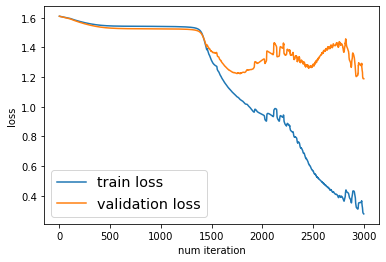

In [115]:
RNN.visualize_loss()